# Info
CIFAR documentation https://www.cs.toronto.edu/~kriz/cifar.html

### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms


### Utils

In [2]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import pathlib
import random
import math

# Allow torch/cudnn to optimize/analyze the input/output shape of convolutions
# To optimize forward/backward pass.
# This will increase model throughput for fixed input shape to the network
torch.backends.cudnn.benchmark = True

# Cudnn is not deterministic by default. Set this to True if you want
# to be sure to reproduce your results
torch.backends.cudnn.deterministic = True


def set_seed(seed: int):
    np.random.seed(seed)
    torch.manual_seed(seed)
    random.seed(seed)


def to_cuda(elements):
    """
    Transfers every object in elements to GPU VRAM if available.
    elements can be a object or list/tuple of objects
    """

    device = get_device()
    if type(elements) == tuple or type(elements) == list:
        return [x.to(device) for x in elements]
    return elements.to(device)


def get_device():
    device = (
        "cuda"
        if torch.cuda.is_available()
        else "mps"
        if torch.backends.mps.is_available()
        else "cpu"
    )
    return device


def save_checkpoint(
    state_dict: dict, filepath: pathlib.Path, is_best: bool, max_keep: int = 1
):
    """
    Saves state_dict to filepath. Deletes old checkpoints as time passes.
    If is_best is toggled, saves a checkpoint to best.ckpt
    """
    filepath.parent.mkdir(exist_ok=True, parents=True)
    list_path = filepath.parent.joinpath("latest_checkpoint")
    torch.save(state_dict, filepath)
    if is_best:
        torch.save(state_dict, filepath.parent.joinpath("best.ckpt"))
    previous_checkpoints = get_previous_checkpoints(filepath.parent)
    if filepath.name not in previous_checkpoints:
        previous_checkpoints = [filepath.name] + previous_checkpoints
    if len(previous_checkpoints) > max_keep:
        for ckpt in previous_checkpoints[max_keep:]:
            path = filepath.parent.joinpath(ckpt)
            if path.exists():
                path.unlink()
    previous_checkpoints = previous_checkpoints[:max_keep]
    with open(list_path, "w") as fp:
        fp.write("\n".join(previous_checkpoints))


def get_previous_checkpoints(directory: pathlib.Path) -> list:
    assert directory.is_dir()
    list_path = directory.joinpath("latest_checkpoint")
    list_path.touch(exist_ok=True)
    with open(list_path) as fp:
        ckpt_list = fp.readlines()
    return [_.strip() for _ in ckpt_list]


def load_best_checkpoint(directory: pathlib.Path):
    filepath = directory.joinpath("best.ckpt")
    if not filepath.is_file():
        return None
    return torch.load(directory.joinpath("best.ckpt"))


def plot_loss(
    loss_dict: dict, label: str = None, npoints_to_average=1, plot_variance=True
):
    """
    Args:
        loss_dict: a dictionary where keys are the global step and values are the given loss / accuracy
        label: a string to use as label in plot legend
        npoints_to_average: Number of points to average plot
    """
    global_steps = list(loss_dict.keys())
    loss = list(loss_dict.values())
    if npoints_to_average == 1 or not plot_variance:
        plt.plot(global_steps, loss, label=label)
        return

    npoints_to_average = 10
    num_points = len(loss) // npoints_to_average
    mean_loss = []
    loss_std = []
    steps = []
    for i in range(num_points):
        points = loss[i * npoints_to_average : (i + 1) * npoints_to_average]
        step = global_steps[i * npoints_to_average + npoints_to_average // 2]
        mean_loss.append(np.mean(points))
        loss_std.append(np.std(points))
        steps.append(step)
    plt.plot(steps, mean_loss, label=f"{label} (mean over {npoints_to_average} steps)")
    plt.fill_between(
        steps,
        np.array(mean_loss) - np.array(loss_std),
        np.array(mean_loss) + loss_std,
        alpha=0.2,
        label=f"{label} variance over {npoints_to_average} steps",
    )

### Dataloaders

In [3]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
import pathlib
np.random.seed(0)

mean = (0.5, 0.5, 0.5)
std = (.25, .25, .25)


def get_data_dir():
    server_dir = pathlib.Path("/work/datasets/cifar10")
    if server_dir.is_dir():
        return str(server_dir)
    return "data/cifar10"


def load_cifar10(batch_size: int, validation_fraction: float = 0.1
                 ) -> typing.List[torch.utils.data.DataLoader]:
    # Note that transform train will apply the same transform for
    # validation!
    transform_train = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])
    data_train = datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test


### Trainer

In [4]:
import torch
import typing
import time
import collections
import pathlib

def compute_loss_and_accuracy(dataloader: torch.utils.data.DataLoader,
                              model: torch.nn.Module,
                              loss_criterion: torch.nn.modules.loss._Loss):
    """
    Computes the average loss and the accuracy over the whole dataset
    in dataloader.
    Args:
        dataloder: Validation/Test dataloader
        model: torch.nn.Module
        loss_criterion: The loss criterion, e.g: torch.nn.CrossEntropyLoss()
    Returns:
        [average_loss, accuracy]: both scalar.
    """
    total_loss = 0  # Initialize total_loss
    total_correct = 0  # Total number of correct predictions
    total_images = 0  # Total number of images processed

    with torch.no_grad():
        for (X_batch, Y_batch) in dataloader:

            # Transfer images/labels to GPU VRAM, if possible
            X_batch = to_cuda(X_batch)
            Y_batch = to_cuda(Y_batch)

            # Forward pass the images through our model
            output_probs = model(X_batch)

            # Compute Loss
            loss = loss_criterion(output_probs, Y_batch)
            total_loss += loss.item() * X_batch.size(0)  # Now correctly scales with batch size

            # Compute Accuracy
            outputs = torch.argmax(output_probs, dim=1)
            total_correct += (outputs == Y_batch).sum().item()
            total_images += Y_batch.size(0)

    average_loss = total_loss / total_images
    accuracy = total_correct / total_images

    return average_loss, accuracy


class Trainer:

    def __init__(self,
                 batch_size: int,
                 learning_rate: float,
                 early_stop_count: int,
                 epochs: int,
                 model: torch.nn.Module,
                 dataloaders: typing.List[torch.utils.data.DataLoader]):
        """
            Initialize our trainer class.
        """
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.early_stop_count = early_stop_count
        self.epochs = epochs

        # Since we are doing multi-class classification, we use CrossEntropyLoss
        self.loss_criterion = torch.nn.CrossEntropyLoss()
        # Initialize the model
        self.model = model
        # Transfer model to GPU VRAM, if possible.
        self.model = to_cuda(self.model)
        print(self.model)

        # Define our optimizer. SGD = Stochastich Gradient Descent
        self.optimizer = torch.optim.SGD(self.model.parameters(),
                                         self.learning_rate)

        # Load our dataset
        self.dataloader_train, self.dataloader_val, self.dataloader_test = dataloaders

        # Validate our model everytime we pass through 50% of the dataset
        self.num_steps_per_val = len(self.dataloader_train) // 2
        self.global_step = 0
        self.start_time = time.time()

        # Tracking variables
        self.train_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()

        )
        self.validation_history = dict(
            loss=collections.OrderedDict(),
            accuracy=collections.OrderedDict()
        )
        self.checkpoint_dir = pathlib.Path("checkpoints")

    def validation_step(self):
        """
            Computes the loss/accuracy for all three datasets.
            Train, validation and test.
        """
        self.model.eval()
        validation_loss, validation_acc = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        self.validation_history["loss"][self.global_step] = validation_loss
        self.validation_history["accuracy"][self.global_step] = validation_acc
        used_time = time.time() - self.start_time
        print(
            f"Epoch: {self.epoch:>1}",
            f"Batches per seconds: {self.global_step / used_time:.2f}",
            f"Global step: {self.global_step:>6}",
            f"Validation Loss: {validation_loss:.2f}",
            f"Validation Accuracy: {validation_acc:.3f}",
            sep=", ")
        self.model.train()

    def should_early_stop(self):
        """
            Checks if validation loss doesn't improve over early_stop_count epochs.
        """
        # Check if we have more than early_stop_count elements in our validation_loss list.
        val_loss = self.validation_history["loss"]
        if len(val_loss) < self.early_stop_count:
            return False
        # We only care about the last [early_stop_count] losses.
        relevant_loss = list(val_loss.values())[-self.early_stop_count:]
        first_loss = relevant_loss[0]
        if first_loss == min(relevant_loss):
            print("Early stop criteria met")
            return True
        return False

    def train_step(self, X_batch, Y_batch):
        """
        Perform forward, backward and gradient descent step here.
        The function is called once for every batch (see trainer.py) to perform the train step.
        The function returns the mean loss value which is then automatically logged in our variable self.train_history.

        Args:
            X: one batch of images
            Y: one batch of labels
        Returns:
            loss value (float) on batch
        """
        # X_batch is the CIFAR10 images. Shape: [batch_size, 3, 32, 32]
        # Y_batch is the CIFAR10 image label. Shape: [batch_size]
        # Transfer images / labels to GPU VRAM, if possible
        X_batch = to_cuda(X_batch)
        Y_batch = to_cuda(Y_batch)

        # Perform the forward pass
        predictions = self.model(X_batch)
        # Compute the cross entropy loss for the batch
        loss = self.loss_criterion(predictions, Y_batch)
        # Backpropagation
        loss.backward()
        # Gradient descent step
        self.optimizer.step()
        # Reset all computed gradients to 0
        self.optimizer.zero_grad()

        return loss.detach().cpu().item()

    def train(self):
        """
        Trains the model for [self.epochs] epochs.
        """
        def should_validate_model():
            return self.global_step % self.num_steps_per_val == 0

        for epoch in range(self.epochs):
            self.epoch = epoch
            # Perform a full pass through all the training samples
            for X_batch, Y_batch in self.dataloader_train:
                loss = self.train_step(X_batch, Y_batch)
                self.train_history["loss"][self.global_step] = loss
                self.global_step += 1
                # Compute loss/accuracy for validation set
                if should_validate_model():
                    self.validation_step()
                    self.save_model()
                    if self.should_early_stop():
                        print("Early stopping.")
                        return

    def save_model(self):
        def is_best_model():
            """
                Returns True if current model has the lowest validation loss
            """
            val_loss = self.validation_history["loss"]
            validation_losses = list(val_loss.values())
            return validation_losses[-1] == min(validation_losses)

        state_dict = self.model.state_dict()
        filepath = self.checkpoint_dir.joinpath(f"{self.global_step}.ckpt")

        save_checkpoint(state_dict, filepath, is_best_model())

    def load_best_model(self):
        state_dict = load_best_checkpoint(self.checkpoint_dir)
        if state_dict is None:
            print(
                f"Could not load best checkpoint. Did not find under: {self.checkpoint_dir}")
            return
        self.model.load_state_dict(state_dict)

    def report_final_accuracies(self):
        """
        Reports the final training, validation, and test accuracies
        """
        # Ensure the model is in evaluation mode
        self.model.eval()

        # Calculate and report training accuracy and loss
        train_loss, train_accuracy = compute_loss_and_accuracy(
            self.dataloader_train, self.model, self.loss_criterion
        )
        print(f"Final Training Loss: {train_loss:.3f}, Final Training Accuracy: {train_accuracy:.3f}")

        # Calculate and report validation accuracy and loss
        val_loss, val_accuracy = compute_loss_and_accuracy(
            self.dataloader_val, self.model, self.loss_criterion
        )
        print(f"Final Validation Loss: {val_loss:.3f}, Final Validation Accuracy: {val_accuracy:.3f}")

        # Calculate and report test accuracy and loss
        test_loss, test_accuracy = compute_loss_and_accuracy(
            self.dataloader_test, self.model, self.loss_criterion
        )
        print(f"Final Test Loss: {test_loss:.3f}, Final Test Accuracy: {test_accuracy:.3f}")

        # Set the model back to training mode
        self.model.train()

def create_plots(trainer: Trainer, name: str):
    plot_path = pathlib.Path("plots")
    plot_path.mkdir(exist_ok=True)
    # Save plots and show them
    plt.figure(figsize=(20, 8))
    plt.subplot(1, 2, 1)
    plt.title("Cross Entropy Loss")
    plot_loss(
        trainer.train_history["loss"], label="Training loss", npoints_to_average=10
    )
    plot_loss(trainer.validation_history["loss"], label="Validation loss")
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.title("Accuracy")
    plot_loss(trainer.validation_history["accuracy"], label="Validation Accuracy")
    plt.legend()
    plt.savefig(plot_path.joinpath(f"{name}_plot.png"))
    plt.show()

### Smaller filter size model. (Filter size = 3)

In [5]:
class SmallFilterModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Define the feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding= 1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Calculate the correct output size of the feature extractor
        # The input image size is 32x32, and each MaxPool2d with kernel_size=2 and stride=2 reduces the size by half
        self.num_output_features = 128 * 4 * 4  # This should match the output size of the feature extractor

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 512),
            nn.ReLU(),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size, -1)
        out = self.classifier(x)
        return out

#### Training the model

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
SmallFilterModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Linear(in_features=2048, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=10, bias=True)
  )
)
Epoch: 0, Batches per seconds: 268.04, Global step:    351, Validation Loss: 1.67, Validation Accuracy: 0.393
Epoch: 0, Batches per seconds: 222.82, 

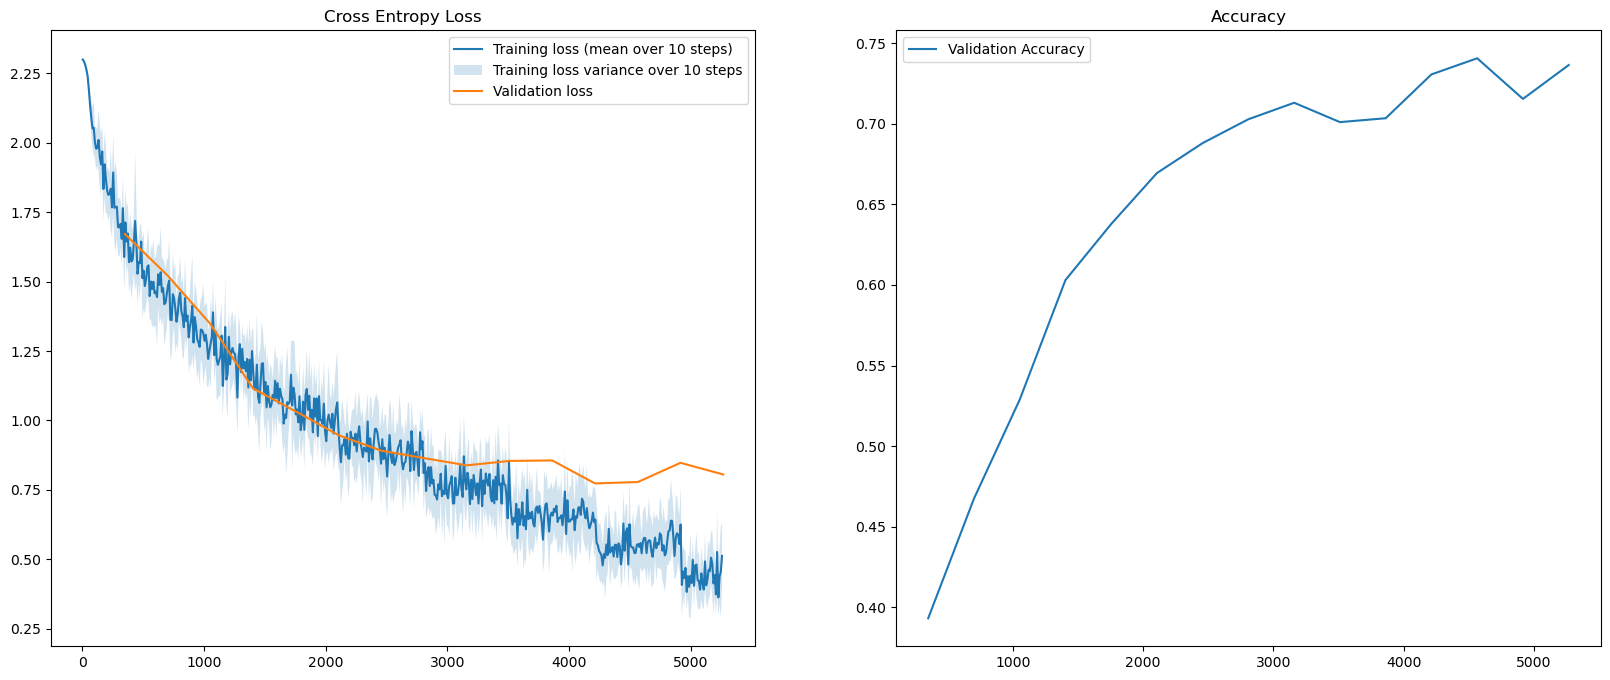

Final Training Loss: 0.421, Final Training Accuracy: 0.858
Final Validation Loss: 0.805, Final Validation Accuracy: 0.736
Final Test Loss: 0.828, Final Test Accuracy: 0.732


In [6]:

set_seed(0)
print(f"Using device: {get_device()}")
epochs = 10
batch_size = 64
learning_rate = 5e-2
early_stop_count = 4
dataloaders = load_cifar10(batch_size)
small_filter_model = SmallFilterModel(image_channels=3, num_classes=10)
small_filter_trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, small_filter_model, dataloaders
)
small_filter_trainer.train()
create_plots(small_filter_trainer, "task3 SmallFilterModel")
small_filter_trainer.model.eval()
small_filter_trainer.report_final_accuracies()

### Large model

In [7]:
import torch
import torch.nn as nn

class LargeModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Define the feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=64, kernel_size=3, padding=1),
            nn.ReLU(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.ReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(0.1),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        self.num_output_features = 256 * 4 * 4

        # Define the classifier
        self.classifier = nn.Sequential(
            nn.Linear(self.num_output_features, 512),
            nn.ReLU(0.1),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = x.view(batch_size, -1)
        out = self.classifier(x)
        return out


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
LargeModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequ

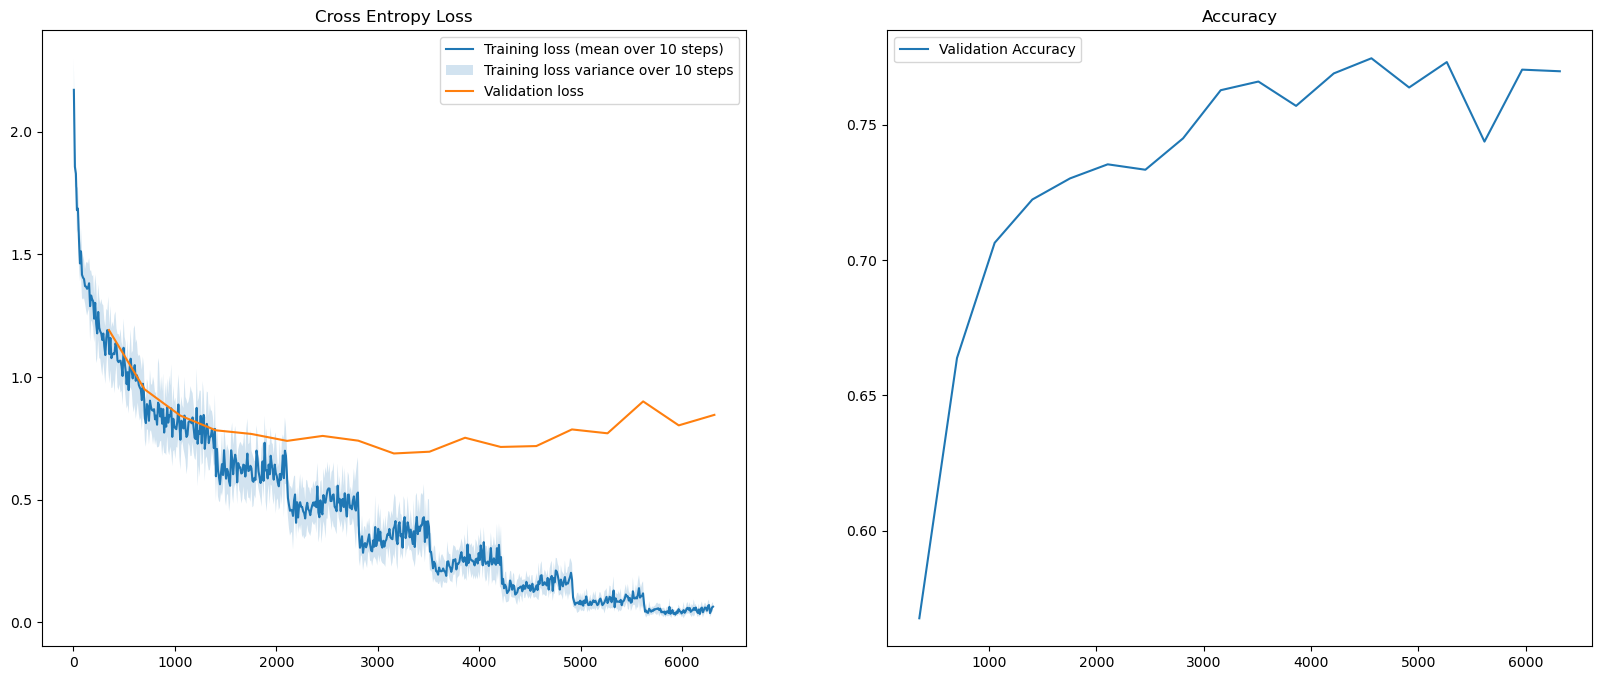

Final Training Loss: 0.038, Final Training Accuracy: 0.994
Final Validation Loss: 0.846, Final Validation Accuracy: 0.770
Final Test Loss: 0.933, Final Test Accuracy: 0.760


In [8]:
set_seed(0)
print(f"Using device: {get_device()}")
epochs = 10
batch_size = 64
learning_rate = 0.01
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
large_model = LargeModel(image_channels=3, num_classes=10)
large_trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, large_model, dataloaders
)
large_trainer.train()
create_plots(large_trainer, "task3 LargerModel")
large_trainer.model.eval()
large_trainer.report_final_accuracies()

### Large Model with Data Augmentation

In [9]:
from torchvision import transforms, datasets
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import typing
import numpy as np
import pathlib
np.random.seed(0)

mean = (0.5, 0.5, 0.5)
std = (.25, .25, .25)

def get_data_dir():
    server_dir = pathlib.Path("/work/datasets/cifar10")
    if server_dir.is_dir():
        return str(server_dir)
    return "data/cifar10"

def load_cifar10(batch_size: int, validation_fraction: float = 0.1) -> typing.List[torch.utils.data.DataLoader]:
    # Updated transform for training with data augmentation
    transform_train = transforms.Compose([
        transforms.RandomHorizontalFlip(),  # Flips the image w.r.t horizontal axis
        transforms.RandomRotation(10),  # Rotates the image to a specified angle
        transforms.ToTensor(),
        transforms.Normalize(mean, std),
    ])

    # Test transformation does not need augmentation
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
    ])

    data_train = datasets.CIFAR10(get_data_dir(),
                                  train=True,
                                  download=True,
                                  transform=transform_train)

    data_test = datasets.CIFAR10(get_data_dir(),
                                 train=False,
                                 download=True,
                                 transform=transform_test)

    indices = list(range(len(data_train)))
    split_idx = int(np.floor(validation_fraction * len(data_train)))

    val_indices = np.random.choice(indices, size=split_idx, replace=False)
    train_indices = list(set(indices) - set(val_indices))

    train_sampler = SubsetRandomSampler(train_indices)
    validation_sampler = SubsetRandomSampler(val_indices)

    dataloader_train = torch.utils.data.DataLoader(data_train,
                                                   sampler=train_sampler,
                                                   batch_size=batch_size,
                                                   num_workers=2,
                                                   drop_last=True)

    dataloader_val = torch.utils.data.DataLoader(data_train,
                                                 sampler=validation_sampler,
                                                 batch_size=batch_size,
                                                 num_workers=2)

    dataloader_test = torch.utils.data.DataLoader(data_test,
                                                  batch_size=batch_size,
                                                  shuffle=False,
                                                  num_workers=2)

    return dataloader_train, dataloader_val, dataloader_test

Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
LargeModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): ReLU(inplace=True)
    (6): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequ

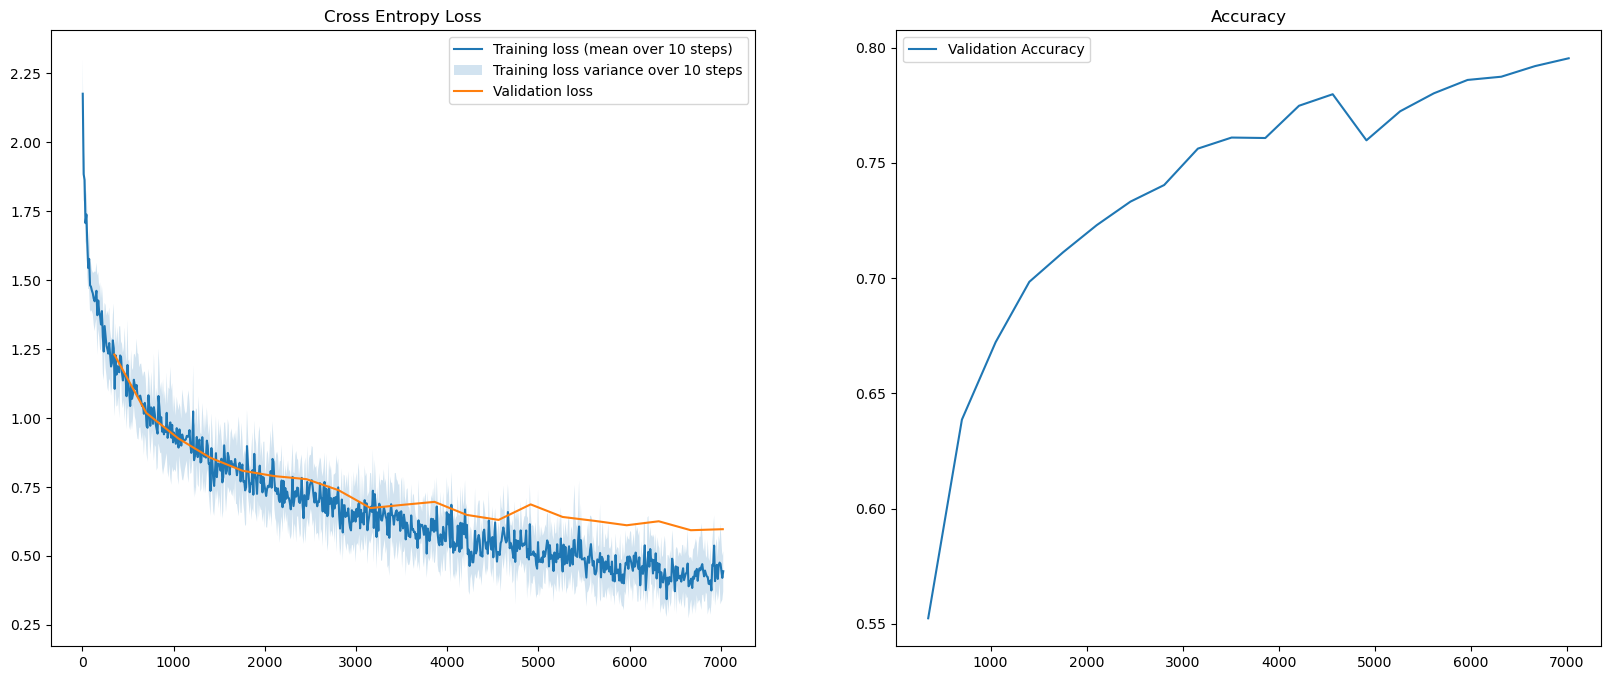

Final Training Loss: 0.376, Final Training Accuracy: 0.873
Final Validation Loss: 0.601, Final Validation Accuracy: 0.793
Final Test Loss: 0.581, Final Test Accuracy: 0.804


In [10]:
set_seed(0)
print(f"Using device: {get_device()}")
epochs = 10
batch_size = 64
learning_rate = 0.01
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
model = LargeModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders
)
trainer.train()
create_plots(trainer, "task3 LargerModel with augmentation")
trainer.model.eval()
trainer.report_final_accuracies()

### Large Model with Data Augmentation, dropout, batchnorm, LeekyReLU and 1 more layer (1024)

In [15]:
import torch.nn as nn

class EnhancedLargeModel(nn.Module):
    def __init__(self, image_channels, num_classes):
        super().__init__()
        self.num_classes = num_classes

        # Feature extractor
        self.feature_extractor = nn.Sequential(
            nn.Conv2d(in_channels=image_channels, out_channels=128, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.Dropout2d(0.1),  
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(256),
            nn.Dropout2d(0.1),  
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(512),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(1024),
            nn.MaxPool2d(kernel_size=2, stride=2) 
        )

        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))  

        # Classifier with dropout
        self.classifier = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 1024),  
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),
            nn.Linear(1024, 1024),
            nn.LeakyReLU(0.1),
            nn.Dropout(0.5),  
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        x = self.feature_extractor(x)
        x = self.adaptive_pool(x)  
        x = x.view(batch_size, -1)  # 
        out = self.classifier(x)
        return out


Using device: cuda
Files already downloaded and verified
Files already downloaded and verified
EnhancedLargeModel(
  (feature_extractor): Sequential(
    (0): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): LeakyReLU(negative_slope=0.1)
    (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout2d(p=0.1, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): LeakyReLU(negative_slope=0.1)
    (7): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): Dropout2d(p=0.1, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): LeakyReLU(negative_slope=0.1)
    (12): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_r

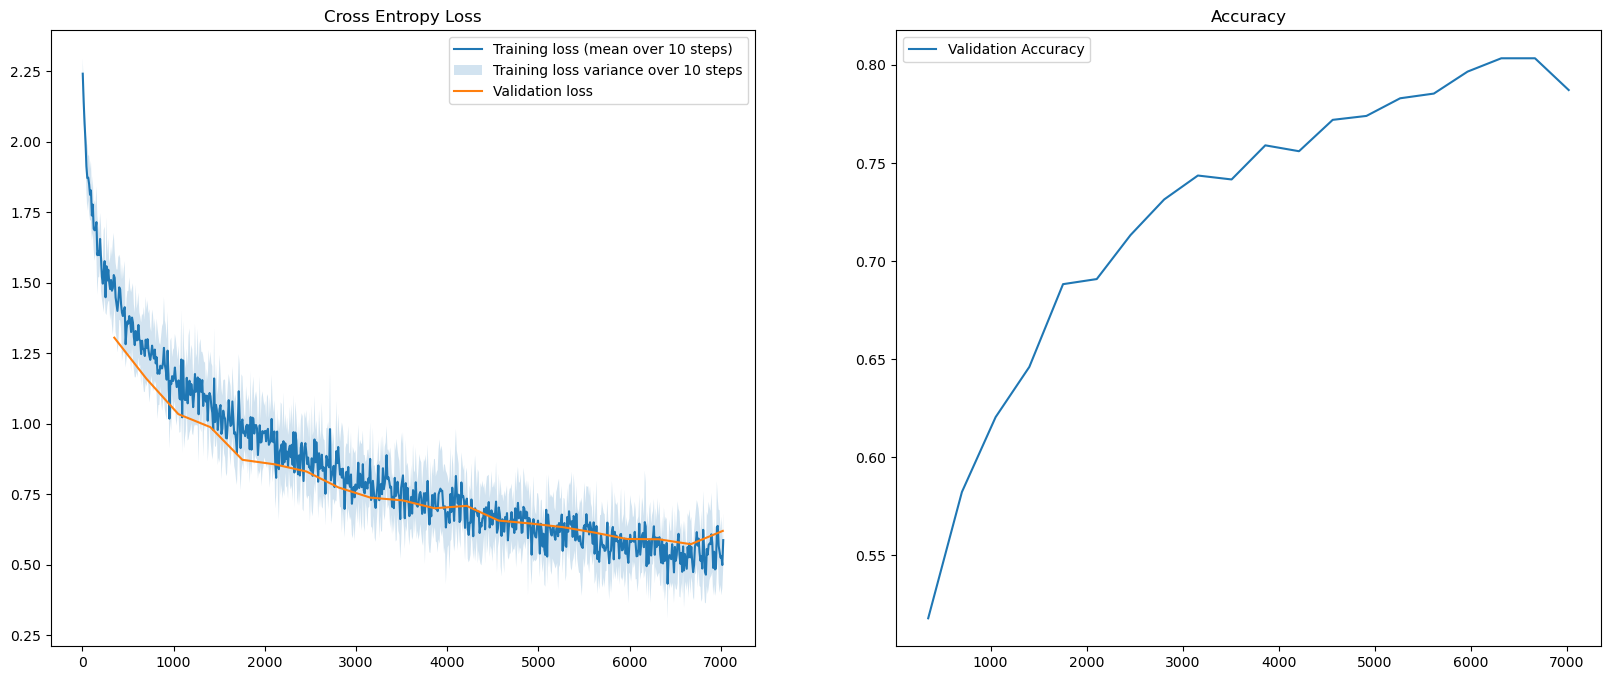

Final Training Loss: 0.376, Final Training Accuracy: 0.870
Final Validation Loss: 0.556, Final Validation Accuracy: 0.809
Final Test Loss: 0.554, Final Test Accuracy: 0.816


In [16]:
set_seed(0)
print(f"Using device: {get_device()}")
epochs = 10
batch_size = 64
learning_rate = 0.01
early_stop_count = 10
dataloaders = load_cifar10(batch_size)
model = EnhancedLargeModel(image_channels=3, num_classes=10)
trainer = Trainer(
    batch_size, learning_rate, early_stop_count, epochs, model, dataloaders
)
trainer.train()
create_plots(trainer, "Enhanced Large Model")
trainer.model.eval()
trainer.report_final_accuracies()